<br>
# Introduction to Machine Learning with Python & Scikit-learn using a Classification Problem

### <span style="color:red">This notebook was created using Python 2.7.12 | Anaconda 4.1.1 (64-bit) | Jupyter 4.2.1</span>

# Predicting if a Person Makes over $50k

### Table of Contents:

- [Obective](#objective)
- [Import Packages](#import)
- [Part I: Data Understanding](#data_understanding)
    - [Data Background](#data_background)
    - [Data Exploration](#data_exploration)
- [Part II: Data Preparation](#data_preparation)
    - [Clean Categorical Variables](#clean_cat_var)
    - [Missing Data](#missing)
    - [Convert Strings to Numeric](#convert)
    - [Variable Correlation](#var_corr)
    - [Prepare for Modeling](#model_prep)
        - [Set Target and Predictor Variables](#set_vars)
        - [Partition Data](#partition)
- [Part III. Modeling](#modeling)
    - [Logistic Regression](#lr)
        - [Fit the model](#lr_fit)
        - [Model Evaluation using the Test Data](#lr_eval)
    - [Decision Tree](#dt)
        - [Fit the model](#dt_fit)
        - [Model Evaluation using the Test Data](#dt_eval)
        - [Visualization of Decision Tree](#dt_visual)
        - [Feature Importance](#dt_var_imp)
    - [Naive Bayes](#naive)
        - [Fit the model](#naive_fit)
        - [Model Evaluation using the Test Data](#naive_eval)
    - [Support Vector Machines](#svm)
        - [Fit the model](#svm_fit)
        - [Model Evaluation using the Test Data](#svm_eval)
- [Part IV: Evaluation](#evaluation)
	- [Model Performance Comparision](#performance_compare)
- [Conclusion](#conclusion)

<a name="objective"></a>
## Objective: 
Predict whether a person makes over $50K a year based on census data. 

<a name="import"></a>
#### Import Packages

Scikit-learn (`Sklearn`) is a Python library for machine learning. Other major Python libraries used in this tutorial include: `Pandas`, `Numpy`, `Matplotlib`, and `Seaborn`. Note that `Seaborn` is not pre-packed in Anaconda and needs to be installed separately. It can be easily installed through the command line using the command `conda install seaborn`.

`Graphviz` package facilitates the creation and rendering of graph descriptions in the DOT language of the Graphviz graph drawing software (repo) from Python. This is used in this notebook to create decision tree visuals. This must be installed separately, but please note that all of the code below will work without installing this except the code block that creates a visual of the decision tree. More info on [Graphviz](https://pypi.python.org/pypi/graphviz).

In [46]:
# show plots in the notebook
%matplotlib inline

# Packages
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from collections import defaultdict
from os import system
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.cross_validation import cross_val_score, StratifiedShuffleSplit

<a name="data_understanding"></a>
# I. Data Understanding

<a name="data_background"></a>
### Data Background

Data Used: Adult Dataset

The "Adult" dataset is hosted on the UC Irvine Machine Learning Repository. The data was extracted from 1994 census data. More information on the dataset is available [here](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names).

The data has already been divided into a training dataset containing thirty two thousand records and a test dataset containing sixteen thousand records. Since there is an abundent amount of data in the train dataset we are going to use only this for the analysis and partition it into our own train and test datasets. 

The data contains 15 variables:
- Age: continuous
- Workclass: 8 values
- Fnlwgt: continuous
- Education: 16 values
- Education_num: continuous
- Marital_status: 7 values
- Occupation: 14 values
- Relationship: 6 values
- Race: 5 values
- Sex: Male, Female
- Capital_gain: continuous
- Capital_loss: continuous
- Hours_per_week: continuous
- Native_country: 41 values
- Income: <=50K, >50K 

### Import Data
The data can be read directly from the url. There are no headers so we have to define them ourselves. Also there is a white space after every comma in the data that we must account for this in `sep` parameter when reading in the data to avoid bring in whitespace.

`Pandas` is a popular Python library for data exploration, manipulation, and analysis. I like to use this library to read data into Python.

In [47]:
# url with data
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Define column names
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'martial_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

# Read the data from the url to a pandas dataframe
# Missing values are represented in the data by "?". You can define strings to be recognized as NaN by the parameter na_values.
df = pd.read_table(url, sep=", ", header=None, names=col_names, engine='python', na_values='?')
    
# Prints the number of rows and columns    
print "Number of rows: " + str(df.shape[0]) + "\nNumber of columns: " + str(df.shape[1])

df.head(10)

Number of rows: 32561
Number of columns: 15


,age,workclass,fnlwgt,education,education_num,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


We will need the target variable converted to numeric. If target = '<=50K' then 0, if target = '>50K' then 1. I will wait to drop the original variable because I will alternate between using the string and numeric versions in plotting.

Drop unneeded variables: 
The `education_num` variable is a numerical form of the education variable so we do not need both. The `fnlwgt` variable is the number of people the census takers believe the observation represents. To keep the analysis simple for demonstrative purposes we will not be using it.

In [48]:
df['target'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

df.drop(['fnlwgt', 'education_num'], axis=1, inplace=True)

<a name="data_exploration"></a>
### Data Exploration

In [49]:
# Summaries: add the “include=’all’” flag to the describe fucntion to get statistics on the non-numeric column types
df.describe(include='all')

,age,workclass,education,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,target
count,32561.000000,30725,32561,32561,30718,32561,32561,32561,32561.000000,32561.000000,32561.000000,31978,32561,32561.000000
unique,NaN,8,16,7,14,6,5,2,NaN,NaN,NaN,41,2,NaN
top,NaN,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K,NaN
freq,NaN,22696,10501,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720,NaN
mean,38.581647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN,0.240810
std,13.640433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN,0.427581
min,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN,0.000000
25%,28.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN,0.000000
50%,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN,0.000000
75%,48.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN,0.000000


In [50]:
# Averages of numeric variables grouped by income
print df.groupby(['target']).mean()

              age  capital_gain  capital_loss  hours_per_week
target                                                       
0       36.783738    148.752468     53.142921       38.840210
1       44.249841   4006.142456    195.001530       45.473026


The `capital_gain` and `capital_loss` are significantly greater for those making an income of >50k. This makes sense since how much money one puts into the market is usually correlated with how much you make. So you would expect those making higher incomes to have more investments, and therefore, more gaines/losses. 

**Note on Plotting:** There are two main plotting libraries in Python, `Matplotlib` and `Seaborn`. While the main plotting library of Python is `Matplotlib`, it can be difficult to tweak and create visually pleasing plots. `Seaborn` is for statistical data visualization built on top of `Matplotlib`. <br> Some benefits to `Seaborn`: 
- Creates visually pleasing plots by default
- Understands the pandas DataFrame so the two work well together
- Creates statistically meaniful plots

I often switch back and forth between the two libraries. The first section of plots below are done in `Matplotlib` and the second section is `Seaborn`. 

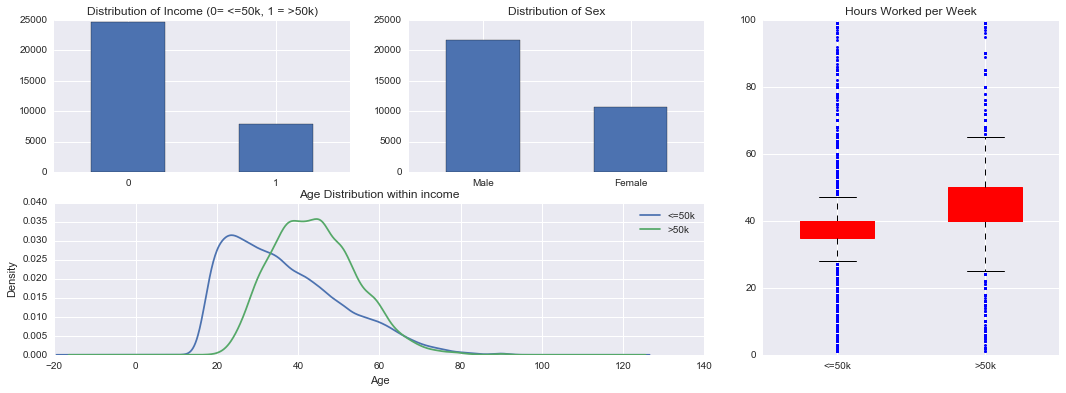

In [51]:
## Plotting using Matplotlib
fig = plt.figure(figsize=(18,6)) 

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of income             
df.target.value_counts().plot(kind='bar')
plt.title("Distribution of Income (0= <=50k, 1 = >50k)")
plt.xticks(rotation=0)

ax2 = plt.subplot2grid((2,3),(0,1))
# plots a bar graph of sex               
df.sex.value_counts().plot(kind='bar')
plt.title("Distribution of Sex")
plt.xticks(rotation=0)

ax3 = plt.subplot2grid((2,3),(0,2), rowspan=2)
# boxplot of hours worked per week by income            
less_50 = [df['hours_per_week'][df['target'] == 0]]
great_50 =[df['hours_per_week'][df['target'] == 1]]
data_to_plot = [less_50, great_50]
bp = plt.boxplot(data_to_plot,patch_artist=True, widths=0.5, labels=['<=50k', '>50k'])
plt.title("Hours Worked per Week")
plt.setp(bp['boxes'], color='red')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='blue', marker='.')

ax4 = plt.subplot2grid((2,3),(1,0), colspan=2)
# Plot of age distribution within income
df.age[df.target == 0].plot(kind='kde')    
df.age[df.target == 1].plot(kind='kde')
plt.xlabel("Age")    
plt.title("Age Distribution within income")
plt.legend(('<=50k', '>50k'),loc='best') 

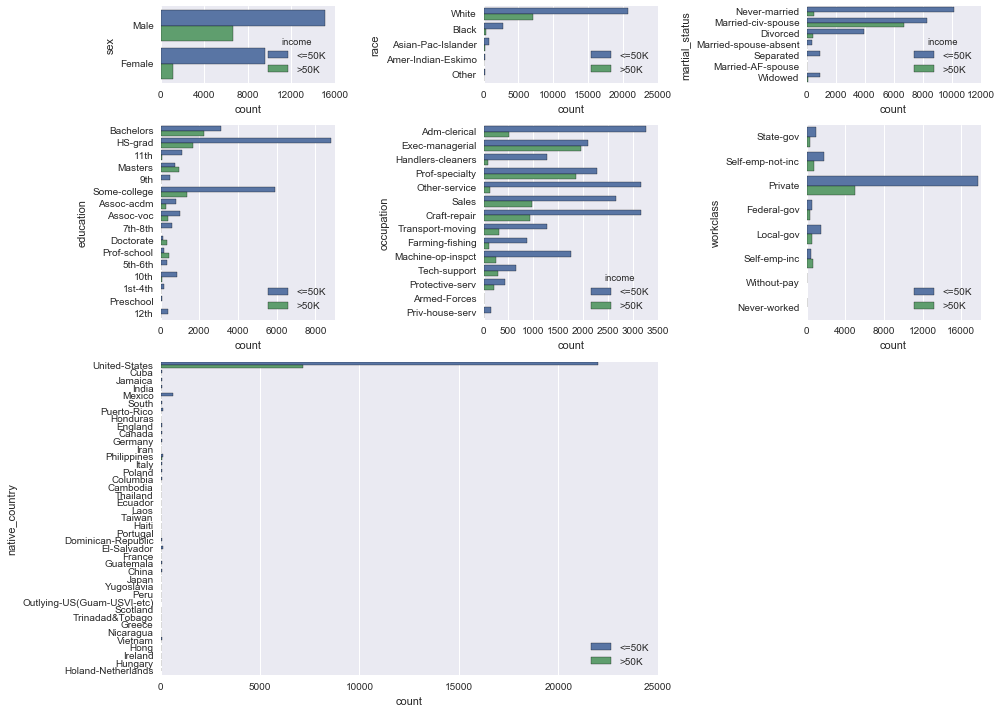

In [52]:
## Plotting using Seaborn
fig = plt.figure(figsize=(14, 10)) 
ax1 = plt.subplot2grid((6,3),(0,0))
sns.countplot(y='sex', hue='income', data=df)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(4000))

ax2 = plt.subplot2grid((6,3),(0,1))
sns.countplot(y='race', hue='income', data=df)
plt.legend(loc='lower right')

ax3 = plt.subplot2grid((6,3),(0,2))
sns.countplot(y='martial_status', hue='income', data=df)

ax4 = plt.subplot2grid((6,3),(1,0), rowspan=2)
sns.countplot(y='education', hue='income', data=df)
plt.legend(loc='lower right')
ax4.xaxis.set_major_locator(ticker.MultipleLocator(2000))

ax5 = plt.subplot2grid((6,3),(1,1), rowspan=2)
sns.countplot(y='occupation', hue='income', data=df)

ax6 = plt.subplot2grid((6,3),(1,2), rowspan=2)
sns.countplot(y='workclass', hue='income', data=df)
plt.legend(loc='lower right')
ax6.xaxis.set_major_locator(ticker.MultipleLocator(4000))

ax7 = plt.subplot2grid((6,3),(3,0), rowspan=5, colspan=2)
sns.countplot(y='native_country', hue='income', data=df)
plt.legend(loc='lower right')

plt.tight_layout()

We learn a lot about the data from the plots above. Roughly 75% of the observations have income <=50k. The hours worked per week is higher for observations where income is >50k. The most frequent age for those making <=50k is in the early to mid-twenties. As age increases, we see a decline in the number making <=50k. The most frequent age for those making >50k is in the mid-thirty to mid-forty range.

The vast majority of observations are in the United States. We can also see values "white", "male", and "private" workclass make up a large number of the observations.

<a name="data_preparation"></a>
# II. Data Preparation

In [53]:
# Drop the income variable, we will be using the numeric version of the variable moving forward.
df.drop(['income'], axis=1, inplace=True)

<a name="clean_cat_var"></a>
#### Clean Categorical Variables
The above plots gave us a good visualization of the data, but let's look closer at the actual distribution of values in the categorical variables.

In [54]:
# You can easily select all variables within a particular dtype by using the 'select_dtypes' method. This is usually cleaner 
# than typing out a list of all the variables you want to keep. In this case we want all the object variables.
categorical_data = df.select_dtypes(include=[object])

for col in categorical_data.columns:
    print "\n" + str(categorical_data[col].value_counts())


Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: martial_status, dtype: int64

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales               

Some of the categorical variables have a lot of different values, which results in some of the values having low frequencies. I want decrease the categories by grouping some of the values together. 

I tried modeling without any changes and then re-ran the model after making a change in the groupings of each variable. In the modeling I saw improvements with each variable modification, except for after changes to `native-country`.

`native_country` is especially an issue since a large percentage of observations are "United-States" and other countries typically have a very low count. To keep it simple, I decided to group countries by common regions, for example United-States, Canada, and Mexico will be grouped into North America. A better way to do this may be to group countries by similar economic conditions. 

In [55]:
def education_groupings(df):
    if df['education'] == '12th' or df['education'] == '11th' or df['education'] == '10th' or df['education'] == '9th':
        group = 'some-HS'
    elif df['education'] == 'Preschool' or df['education'] == '1st-4th' or df['education'] == '5th-6th' or df['education'] == '7th-8th':
        group = 'dropout-before-HS'
    elif df['education'] == 'Assoc-voc' or df['education'] == 'Assoc-acdm':
        group = 'associates'
    else:
        group = df['education']
    return group    

df['education'] = df.apply(education_groupings, axis=1)

In [56]:
df['education'].value_counts()

HS-grad              10501
Some-college          7291
Bachelors             5355
some-HS               3055
associates            2449
Masters               1723
dropout-before-HS     1198
Prof-school            576
Doctorate              413
Name: education, dtype: int64

In [57]:
def marital_groupings(df):
    if df['martial_status'] == 'Married-civ-spouse' or df['martial_status'] == 'Married-AF-spouse' or df['martial_status'] == 'Married-spouse-absent':
        group = 'Married'
    elif df['martial_status'] == 'Divorced' or df['martial_status'] == 'Separated' or df['martial_status'] == 'Widowed':
        group = 'Not-married'
    else:
        group = df['martial_status']
    return group    

df['martial_status'] = df.apply(marital_groupings, axis=1)

In [58]:
df['martial_status'].value_counts()

Married          15417
Never-married    10683
Not-married       6461
Name: martial_status, dtype: int64

In [59]:
def workclass_groupings(df):
    if df['workclass'] == 'Self-emp-not-inc' or df['workclass'] == 'Self-emp-inc':
        group = 'Self-employed'
    elif df['workclass'] == 'Local-gov' or df['workclass'] == 'State-gov' or df['workclass'] == 'Federal-gov':
        group = 'Government'
    elif df['workclass'] == 'Without-pay' or df['workclass'] == 'Never-worked':
        group = 'Not-employed'
    else:
        group = df['workclass']
    return group    

df['workclass'] = df.apply(workclass_groupings, axis=1)

In [60]:
df['workclass'].value_counts()

Private          22696
Government        4351
Self-employed     3657
Not-employed        21
Name: workclass, dtype: int64

In [61]:
def country_groupings(df):     
    if (df['native_country'] == 'United-States'
        or df['native_country'] == 'Outlying-US(Guam-USVI-etc)'
        or df['native_country'] == 'Mexico'
        or df['native_country'] == 'Canada'):
        group = 'North America'
    elif (df['native_country'] == 'Honduras' 
          or df['native_country'] == 'Guatemala'
          or df['native_country'] == 'Nicaragua'
          or df['native_country'] == 'El-Salvador'):
        group = 'Central America'
    elif (df['native_country'] == 'Peru' 
          or df['native_country'] == 'Ecuador' 
          or df['native_country'] == 'Columbia'):
        group = 'South America'
    elif (df['native_country'] == 'Cuba' 
          or df['native_country'] == 'Dominican-Republic' 
          or df['native_country'] == 'Haiti'
          or df['native_country'] == 'Puerto-Rico'
          or df['native_country'] == 'Trinadad&Tobago'
          or df['native_country'] == 'Jamaica'):
        group = 'Caribbean'
    elif (df['native_country'] == 'Germany' 
          or df['native_country'] == 'England'
          or df['native_country'] == 'Portugal'
          or df['native_country'] == 'France'
          or df['native_country'] == 'Greece'
          or df['native_country'] == 'Ireland'
          or df['native_country'] == 'Poland'
          or df['native_country'] == 'Italy'
          or df['native_country'] == 'Hungary'
          or df['native_country'] == 'Scotland'
          or df['native_country'] == 'Holand-Netherlands'
          or df['native_country'] == 'Yugoslavia'):
        group = 'Europe'
    elif (df['native_country'] == 'Philippines' 
          or df['native_country'] == 'India' 
          or df['native_country'] == 'China'
          or df['native_country'] == 'Vietnam'
          or df['native_country'] == 'Japan'
          or df['native_country'] == 'Taiwan'
          or df['native_country'] == 'Iran'
          or df['native_country'] == 'Hong'
          or df['native_country'] == 'Cambodia'
          or df['native_country'] == 'Laos'
          or df['native_country'] == 'Thailand'
          or df['native_country'] == 'Iran'
          or df['native_country'] == 'Hong'
          or df['native_country'] == 'Cambodia'
          or df['native_country'] == 'Laos'):
        group = 'Asia'
    elif df['native_country'] == 'South':
        group = 'Other'
    else:
        group = df['native_country']
    return group    

df['native_country'] = df.apply(country_groupings, axis=1)

In [62]:
df['native_country'].value_counts()

North America      29948
Asia                 671
Europe               521
Caribbean            423
Central America      217
South America        118
Other                 80
Name: native_country, dtype: int64

<a name="missing"></a>
#### Missing Data

In [63]:
# Check for missing data
def missingPct(df):
    num = df.isnull().sum()
    den = df.count()
    return 100*(num/den)

missingPct(df)

age               0.000000
workclass         5.975590
education         0.000000
martial_status    0.000000
occupation        5.999740
relationship      0.000000
race              0.000000
sex               0.000000
capital_gain      0.000000
capital_loss      0.000000
hours_per_week    0.000000
native_country    1.823128
target            0.000000
dtype: float64

The missing values are limited to string variables. The label encoder below will convert missing values to 0. If I had numeric variables with missing values then I would consider replacing missing values with the column mean, frequency, etc.

<a name="convert"></a>
#### Convert Strings to Numeric

In [64]:
df.dtypes

# If you wanted to select only columns of a certain type you could filter like below (this example filters for only numeric columns):
#df = df.select_dtypes(include=[np.number])

age                int64
workclass         object
education         object
martial_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
target             int64
dtype: object

In most cases, models such as decision trees and random forests can handle categorical input variables, but this is not the case when using `Sklearn` in Python. `Sklearn` only handles numeric variables. `Sklearn` inclues several pre-processing tools that offer a few different methods to encode categorical data to numbers. Some methods are `OneHotEncoder`, `LabelEncoder`, and `DictVectorizor`. `Pandas` also offers something similar, `get_dummies`, which converts categorical variable into dummy/indicator variables. This is a bit easier than using `OneHotEncoder` which cannot process string values directly, so you have to convert to integers before using. 
I recommend doing some research to know which one is appropriate for your particular data. Using functions like `get_dummies` and `OneHotEncoder` can really increase the size of your dataset if your variables have a lot of categories. Also consider how these handle NaN values.

A high level overview: <br>
One-Hot: creates one column per cateogry with a 1 or 0. The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features. <br>
LabelEncoder: Encode labels with value between 0 and n_classes-1. <br>
DictVectorizor: Transforms lists of feature-value mappings to vectors. <br>
Get_dummies: Convert categorical variable into dummy/indicator variables.

*I will do two examples of encoding (`get_dummies` and  `LabelEncoder`) for demonstration. However, I'm only going to use one of these methods (`LabelEncoder`) for the modeling to keep this tutorial clean and simple. If you have time, it would be a good exercise to try both ways of encoding and compare the model performance to see which method is better for this data. *

In [65]:
# Using `get_dummies` to encode strings. This method ignores NaN values.
df_dummies = pd.get_dummies(df, columns = ['workclass', 'education', 'martial_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'])
print df_dummies.columns
df_dummies.head()

Index([u'age', u'capital_gain', u'capital_loss', u'hours_per_week', u'target',
       u'workclass_Government', u'workclass_Not-employed',
       u'workclass_Private', u'workclass_Self-employed',
       u'education_Bachelors', u'education_Doctorate', u'education_HS-grad',
       u'education_Masters', u'education_Prof-school',
       u'education_Some-college', u'education_associates',
       u'education_dropout-before-HS', u'education_some-HS',
       u'martial_status_Married', u'martial_status_Never-married',
       u'martial_status_Not-married', u'occupation_Adm-clerical',
       u'occupation_Armed-Forces', u'occupation_Craft-repair',
       u'occupation_Exec-managerial', u'occupation_Farming-fishing',
       u'occupation_Handlers-cleaners', u'occupation_Machine-op-inspct',
       u'occupation_Other-service', u'occupation_Priv-house-serv',
       u'occupation_Prof-specialty', u'occupation_Protective-serv',
       u'occupation_Sales', u'occupation_Tech-support',
       u'occupation_Tran

,age,capital_gain,capital_loss,hours_per_week,target,workclass_Government,workclass_Not-employed,workclass_Private,workclass_Self-employed,education_Bachelors,...,race_White,sex_Female,sex_Male,native_country_Asia,native_country_Caribbean,native_country_Central America,native_country_Europe,native_country_North America,native_country_Other,native_country_South America
0,39,2174,0,40,0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50,0,0,13,0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38,0,0,40,0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53,0,0,40,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,0,0,40,0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Using `LabelEncoder` to encode strings. This method assigns NaN values to category.
d = defaultdict(LabelEncoder)
df_le = df.apply(lambda x: d[x.name].fit_transform(x))
df_le.head()

,age,workclass,education,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,22,1,0,1,1,1,4,1,25,0,39,5,0
1,33,4,0,0,4,0,4,1,0,0,12,5,0
2,21,3,2,2,6,1,4,1,0,0,39,5,0
3,36,3,8,0,6,0,2,1,0,0,39,5,0
4,11,3,0,0,10,5,2,0,0,0,39,2,0


The code below shows the mapping between the string values and the encoding to integers.

In [67]:
# New dataframe with only the categorical variables
df_cat_vars = df[['workclass', 'education', 'martial_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']]
# Rename columns before concatenating the two dataframes
df_cat_vars.columns = [str(col) + '_string' for col in df_cat_vars.columns]

# Concatenate the dataframe with the categorical variables that are still in string format with the new enconded dataframe 
df_map = pd.concat([df_cat_vars, df_le], axis=1)

# Take the pair of variables and get the distinct mapping. 
print str(df_map[['workclass_string', 'workclass']].drop_duplicates().sort_values('workclass')) + '\n' + \
      '\n' + str(df_map[['education_string', 'education']].drop_duplicates().sort_values('education'))  + '\n' + \
      '\n' + str(df_map[['martial_status_string', 'martial_status']].drop_duplicates().sort_values('martial_status')) + '\n' + \
      '\n' + str(df_map[['occupation_string', 'occupation']].drop_duplicates().sort_values('occupation')) + '\n' + \
      '\n' + str(df_map[['relationship_string', 'relationship']].drop_duplicates().sort_values('relationship')) + '\n' + \
      '\n' + str(df_map[['race_string', 'race']].drop_duplicates().sort_values('race')) + '\n' + \
      '\n' + str(df_map[['sex_string', 'sex']].drop_duplicates().sort_values('sex')) + '\n' + \
      '\n' + str(df_map[['native_country_string', 'native_country']].drop_duplicates().sort_values('native_country'))

     workclass_string  workclass
27                NaN          0
0          Government          1
1901     Not-employed          2
2             Private          3
1       Self-employed          4

     education_string  education
0           Bachelors          0
20          Doctorate          1
2             HS-grad          2
5             Masters          3
52        Prof-school          4
10       Some-college          5
13         associates          6
15  dropout-before-HS          7
3             some-HS          8

  martial_status_string  martial_status
1               Married               0
0         Never-married               1
2           Not-married               2

     occupation_string  occupation
27                 NaN           0
0         Adm-clerical           1
442       Armed-Forces           2
14        Craft-repair           3
1      Exec-managerial           4
16     Farming-fishing           5
2    Handlers-cleaners           6
17   Machine-op-inspct       

<a name="var_corr"></a>
#### Variable Correlation

In [68]:
# Correlation matrix 
corr = df_le.corr()
corr

,age,workclass,education,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
age,1.000000,-0.025818,-0.064541,-0.086672,-0.020930,-0.263783,0.028752,0.088863,0.125916,0.065058,0.069123,-0.001043,0.234134
workclass,-0.025818,1.000000,-0.015815,-0.072888,0.238362,-0.092006,0.067558,0.112791,0.032230,0.016290,0.161596,-0.015442,0.044685
education,-0.064541,-0.015815,1.000000,0.068765,-0.051015,0.091789,-0.021760,-0.034860,-0.075749,-0.043733,-0.135556,0.010988,-0.184411
martial_status,-0.086672,-0.072888,0.068765,1.000000,-0.051019,0.457735,-0.066238,-0.440807,-0.117467,-0.067906,-0.153703,0.036509,-0.368851
occupation,-0.020930,0.238362,-0.051015,-0.051019,1.000000,-0.075607,0.006763,0.080296,0.026252,0.017342,0.080621,-0.009944,0.075468
relationship,-0.263783,-0.092006,0.091789,0.457735,-0.075607,1.000000,-0.116055,-0.582454,-0.093147,-0.064284,-0.251352,-0.009207,-0.250918
race,0.028752,0.067558,-0.021760,-0.066238,0.006763,-0.116055,1.000000,0.087204,0.024960,0.019363,0.042318,0.294879,0.071846
sex,0.088863,0.112791,-0.034860,-0.440807,0.080296,-0.582454,0.087204,1.000000,0.077589,0.049544,0.231355,-0.004283,0.215980
capital_gain,0.125916,0.032230,-0.075749,-0.117467,0.026252,-0.093147,0.024960,0.077589,1.000000,-0.056970,0.101365,0.000322,0.340016
capital_loss,0.065058,0.016290,-0.043733,-0.067906,0.017342,-0.064284,0.019363,0.049544,-0.056970,1.000000,0.058826,-0.006140,0.162514


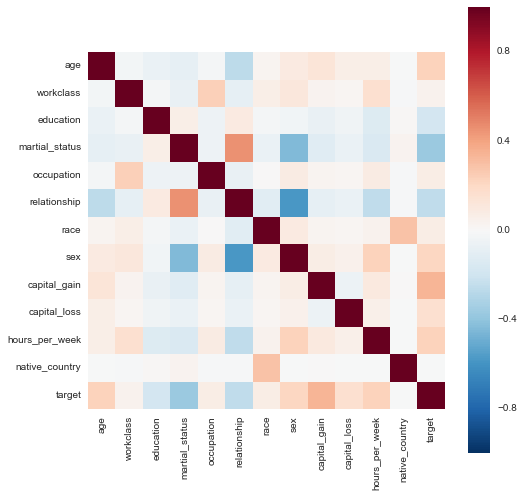

In [69]:
# Correlation matrix heat map
plt.figure(figsize=(8, 8))
sns.heatmap(corr, vmax=1, square=True)

There are no highly correlated variables in the data.

<a name="model_prep"></a>
### Prepare for Modeling
<a name="set_vars"></a>
#### Set target and predictor variables

In [70]:
# Set the predictor variables and target variable
target = df_le['target']
predictors = df_le.drop(['target'], axis=1)

<a name="partition"></a>
#### Partition Data
The Stratified Shufflesplit returns stratified randomized folds with equal percentages of the target variable in the train and test datasets.

* **X_train** - Training Predictors 
* **y_train** - Training Target
* **X_test** - Testing Predictors
* **y_test** - Testing Target

In [71]:
# Partition modeling_df into TRAIN and TEST datasets (80% Train VS 20% Test)
seed = 2342

sss = StratifiedShuffleSplit(target, n_iter=1, test_size=0.2, random_state=seed)

for train_index, test_index in sss:
    X_train, X_test = predictors.iloc[train_index], predictors.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

# What percentage of people have income >50k
print "\n" + str(format(y_train.mean() * 100,'.3f')) + "% of people with an income >50k in training data\n" + \
      str(format(y_test.mean() * 100,'.3f')) + "% of people with an income >50k in testing data\n"

# Check target series for distribution of classes
print y_train.value_counts()
print y_test.value_counts()    

print "\n" + str(len(predictors)) + " total records split into: \n" + \
      str(len(X_train)) + " records - 80% train \n" + \
      str(len(X_test)) + " records - 20% test"


24.082% of people with an income >50k in training data
24.075% of people with an income >50k in testing data

0    19775
1     6273
Name: target, dtype: int64
0    4945
1    1568
Name: target, dtype: int64

32561 total records split into: 
26048 records - 80% train 
6513 records - 20% test


<a name="modeling"></a>
# III. Modeling

There are many different ways to evaluate model performance and these will differ based on if your building a regression or classification model. I've provided several methods in each of my model evaluations for demonstration purposes. The sklearn metrics module provides various functions for model evaluation.

`accuracy_score` function computes the accuracy classification score.

Error Rate is just 1 minus the accuracy score.

`roc_auc_score` computes the Area Under the Curve (AUC) from prediction scores.

`mean_squared_error` function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error loss or loss.

Root Mean Squared Error (RMSE) can easily be calculated by taking the square root of the `mean_squared_error`. Import `sqrt` by calling `from math import sqrt`

`r2_score` (R Squared) metric provides an indication of the goodness of fit of a set of predictions to the actual values. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

Gini Coefficient can be derived from the AUC as 2*AUC-1. Gini above 60% is a good model.

`confusion_matrix` is the count of true negatives, false negatives, true positives, and false positives.

`classification_report` function builds a report with the main classification metrics. Metrics included:
- Precision computes the proportion of instances predicted as positives that were correctly evaluated (it measures how right is our classifier when it says that an instance is positive).
- Recall counts the proportion of positive instances that were correctly evaluated (measuring how right our classifier is when faced with a positive instance).
- F1-score is the harmonic mean of precision and recall, and tries to combine both in a single number.

**ROC Chart ** <br>
The ROC chart is similar to the gain or lift charts in that they provide a means of comparison between classification models. The ROC chart shows false positive rate (1-specificity) on X-axis, the probability of target=1 when its true value is 0, against true positive rate (sensitivity) on Y-axis, the probability of target=1 when its true value is 1. Ideally, the curve will climb quickly toward the top-left meaning the model correctly predicted the cases. The diagonal red line is for a random model

**Area Under the Curve (AUC)** <br>
Area under ROC curve is often used as a measure of quality of the classification models. A random classifier has an area under the curve of 0.5, while AUC for a perfect classifier is equal to 1. In practice, most of the classification models have an AUC between 0.5 and 1.

<a name="lr"></a>
## Logistic Regression

Sklearn documenation on [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

<a name="lr_fit"></a>
#### Fit the model

In [72]:
lr = LogisticRegression()

# fit the model
lr.fit(X_train, y_train)

# check the accuracy on the training set
lr.score(X_train, y_train)
print "\n" + str(format(lr.score(X_train, y_train) * 100, '.3f')) + "% training model accuracy"


81.200% training model accuracy


<a name="lr_eval"></a>
#### Model Evaluation using the Test Data

In [73]:
# Make Predictions
lr_predicted = lr.predict(X_test)

print "\nLogistic Regression \nResidual Sum of Squares:  " + \
    str(((lr.predict(X_test) - y_test) ** 2).sum()) + \
    "\nAccuracy Score:           " + \
    str(format(metrics.accuracy_score(y_test, lr_predicted), '.3f')) + \
    "\nError Rate:               " + \
    str(format((1 - metrics.accuracy_score(y_test, lr_predicted)), '.3f')) + \
    "\nROC AUC Score:            " + \
    str(format(metrics.roc_auc_score(y_test, lr.predict(X_test)), '.3f')) + \
    "\nMean Squared Error:       " + \
    str(format(metrics.mean_squared_error(y_test, lr_predicted), '.3f')) + \
    "\nRMSE:                     " + \
    str(format(sqrt(metrics.mean_squared_error(y_test, lr_predicted)), '.3f')) + \
    "\nR2:                       " + \
    str(format(metrics.r2_score(y_test, lr_predicted), '.3f')) + \
    "\n\nConfusion Matrix: \n" + \
    str(metrics.confusion_matrix(y_test, lr_predicted)) + \
    "\n(row=expected, col=predicted)" +     \
    "\n\nClassification Report: \n" +\
    str(metrics.classification_report(y_test,lr_predicted))


Logistic Regression 
Residual Sum of Squares:  1217
Accuracy Score:           0.813
Error Rate:               0.187
ROC AUC Score:            0.682
Mean Squared Error:       0.187
RMSE:                     0.432
R2:                       -0.022

Confusion Matrix: 
[[4621  324]
 [ 893  675]]
(row=expected, col=predicted)

Classification Report: 
             precision    recall  f1-score   support

          0       0.84      0.93      0.88      4945
          1       0.68      0.43      0.53      1568

avg / total       0.80      0.81      0.80      6513



The Area Under the ROC Curve: 0.856729
Gini: 0.713


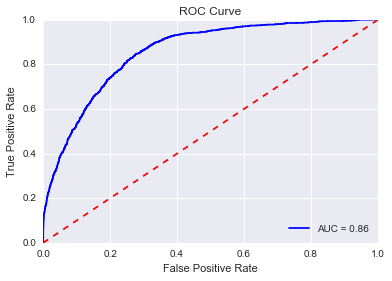

In [74]:
probas = lr.predict_proba(X_test)
lr_preds = probas[:,1]

# calculate the fpr and tpr for all thresholds of the classification
lr_fpr, lr_tpr, lr_threshold = metrics.roc_curve(y_test, lr_preds)
lr_roc_auc = metrics.auc(lr_fpr, lr_tpr)

print "The Area Under the ROC Curve: %f" % lr_roc_auc + \
      "\nGini: " + str(format(2*lr_roc_auc-1, '.3f'))
    
# plot ROC curve
plt.title('ROC Curve')
plt.plot(lr_fpr, lr_tpr, 'b', label = 'AUC = %0.2f' % lr_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a name="dt"></a>
## Decision Tree

Scikit-learn has several types of Decision Trees. Do research to find the correct one for your data. Scikit-learn uses an optimised version of the CART algorithm. Sklearn documenation on [decision trees](http://scikit-learn.org/stable/modules/tree.html#regression).

Use max_depth=3 as an initial tree depth to get a feel for how the tree is fitting to your data, and then increase the depth. Use max_depth to control the size of the tree to prevent overfitting. Use min_samples_split or min_samples_leaf to control the number of samples at a leaf node. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data. Try min_samples_leaf=5 as an initial value.

<a name="dt_fit"></a>
#### Fit the model

In [75]:
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=99)
dt.fit(X_train, y_train)

print "\n" + str(format(dt.score(X_train, y_train) * 100, '.3f')) + "% training model accuracy"


82.417% training model accuracy


<a name="dt_eval"></a>
#### Model Evaluation using the Test Data

In [76]:
# Make Predictions
dt_predicted = dt.predict(X_test)

print "\nDecision Tree \nResidual Sum of Squares:  " + \
    str(((dt.predict(X_test) - y_test) ** 2).sum()) + \
    "\nAccuracy Score:           " + \
    str(format(metrics.accuracy_score(y_test, dt_predicted), '.3f')) + \
    "\nError Rate:               " + \
    str(format((1 - metrics.accuracy_score(y_test, dt_predicted)), '.3f')) + \
    "\nROC AUC Score:            " + \
    str(format(metrics.roc_auc_score(y_test, dt.predict(X_test)), '.3f')) + \
    "\nMean Squared Error:       " + \
    str(format(metrics.mean_squared_error(y_test, dt_predicted), '.3f')) + \
    "\nRMSE:                     " + \
    str(format(sqrt(metrics.mean_squared_error(y_test, dt_predicted)), '.3f')) + \
    "\nR2:                       " + \
    str(format(metrics.r2_score(y_test, dt_predicted), '.3f')) + \
    "\n\nConfusion Matrix: \n" + \
    str(metrics.confusion_matrix(y_test, dt_predicted)) + \
    "\n(row=expected, col=predicted)" +     \
    "\n\nClassification Report: \n" + \
    str(metrics.classification_report(y_test,dt_predicted))


Decision Tree 
Residual Sum of Squares:  1109
Accuracy Score:           0.830
Error Rate:               0.170
ROC AUC Score:            0.693
Mean Squared Error:       0.170
RMSE:                     0.413
R2:                       0.068

Confusion Matrix: 
[[4732  213]
 [ 896  672]]
(row=expected, col=predicted)

Classification Report: 
             precision    recall  f1-score   support

          0       0.84      0.96      0.90      4945
          1       0.76      0.43      0.55      1568

avg / total       0.82      0.83      0.81      6513



<a name="dt_visual"></a>
#### Visualization of Decision Tree
Note: Creating a visual of a decision tree in Jupyter is not easy...still working on the code below. Installation of Graphviz can be difficult so research how to do this carefully. Double click the image below to zoom-in if it appears small and difficult to read.

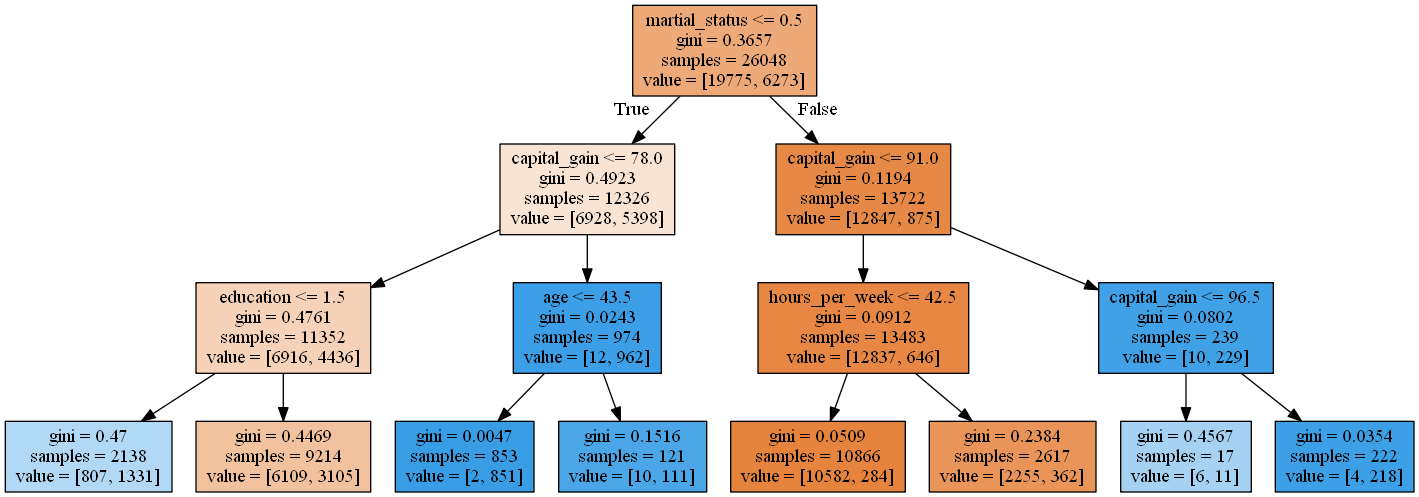

In [77]:
# Output dot language script
dotfile = open("classification_dtree.dot", 'w')
export_graphviz(dt, out_file = dotfile, feature_names = X_train.columns, filled=True)
dotfile.close()

# Call system to convert dot file to jpg and then display it in Jupyter.
system("dot -Tpng classification_dtree.dot -o classification_dtree.jpg")
Image(filename='classification_dtree.jpg') 

<a name="dt_var_imp"></a>
#### Feature Importance

In [78]:
# Top 5 most important features
print "Feature Importance (Top 5): "
print pd.DataFrame(dt.feature_importances_, columns = ["Imp"], index = predictors.columns).sort_values(['Imp'], ascending = False).head(5)

Feature Importance (Top 5): 
                     Imp
martial_status  0.570394
capital_gain    0.323735
education       0.088786
hours_per_week  0.016656
age             0.000429


The Area Under the ROC Curve: 0.842372
Gini: 0.685


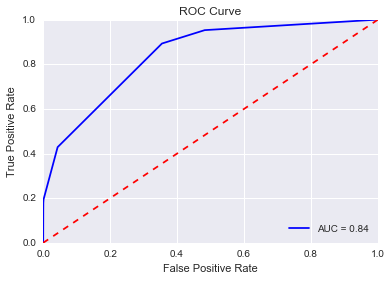

In [79]:
# calculate the fpr and tpr for all thresholds of the classification
probas = dt.predict_proba(X_test)
dt_preds = probas[:,1]
dt_fpr, dt_tpr, dt_threshold = metrics.roc_curve(y_test, dt_preds)
dt_roc_auc = metrics.auc(dt_fpr, dt_tpr)

print "The Area Under the ROC Curve: %f" % dt_roc_auc + \
      "\nGini: " + str(format(2*dt_roc_auc-1, '.3f'))
    
# plot ROC curve
plt.title('ROC Curve')
plt.plot(dt_fpr, dt_tpr, 'b', label = 'AUC = %0.2f' % dt_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a name="naive"></a>
## Naive Bayes

Sklearn has a few different naive bayes algorithms. Below I show the Gaussian Naive Bayes (GaussianNB). Sklearn documenation on [Gaussian naive bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html).

<a name="naive_fit"></a>
#### Fit the model

In [80]:
# GaussianNB implements the Gaussian Naive Bayes algorithm for classification.
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print "\n" + str(format(gnb.score(X_train, y_train) * 100, '.3f')) + "% training model accuracy"


80.056% training model accuracy


<a name="naive_eval"></a>
#### Model Evaluation using the Test Data

In [81]:
# Make Predictions
gnb_predicted = gnb.predict(X_test)

print "\nNaive Bayes \nResidual Sum of Squares:  " + \
    str(((gnb.predict(X_test) - y_test) ** 2).sum()) + \
    "\nAccuracy Score:           " + \
    str(format(metrics.accuracy_score(y_test, gnb_predicted), '.3f')) + \
    "\nError Rate:               " + \
    str(format((1 - metrics.accuracy_score(y_test, gnb_predicted)), '.3f')) + \
    "\nROC AUC Score:            " + \
    str(format(metrics.roc_auc_score(y_test, gnb.predict(X_test)), '.3f')) + \
    "\nMean Squared Error:       " + \
    str(format(metrics.mean_squared_error(y_test, gnb_predicted), '.3f')) + \
    "\nRMSE:                     " + \
    str(format(sqrt(metrics.mean_squared_error(y_test, gnb_predicted)), '.3f')) + \
    "\nR2:                       " + \
    str(format(metrics.r2_score(y_test, gnb_predicted), '.3f')) + \
    "\n\nConfusion Matrix: \n" + \
    str(metrics.confusion_matrix(y_test, gnb_predicted)) + \
    "\n(row=expected, col=predicted)" +     \
    "\n\nClassification Report: \n" +\
    str(metrics.classification_report(y_test,gnb_predicted)) 


Naive Bayes 
Residual Sum of Squares:  1293
Accuracy Score:           0.801
Error Rate:               0.199
ROC AUC Score:            0.661
Mean Squared Error:       0.199
RMSE:                     0.446
R2:                       -0.086

Confusion Matrix: 
[[4608  337]
 [ 956  612]]
(row=expected, col=predicted)

Classification Report: 
             precision    recall  f1-score   support

          0       0.83      0.93      0.88      4945
          1       0.64      0.39      0.49      1568

avg / total       0.78      0.80      0.78      6513



The Area Under the ROC Curve: 0.832890
Gini: 0.666


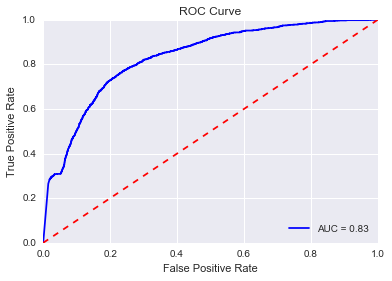

In [82]:
# calculate the fpr and tpr for all thresholds of the classification
probas = gnb.predict_proba(X_test)
gnb_preds = probas[:,1]
gnb_fpr, gnb_tpr, gnb_threshold = metrics.roc_curve(y_test, gnb_preds)
gnb_roc_auc = metrics.auc(gnb_fpr, gnb_tpr)

print "The Area Under the ROC Curve: %f" % gnb_roc_auc + \
      "\nGini: " + str(format(2*gnb_roc_auc-1, '.3f'))
    
# plot ROC curve
plt.title('ROC Curve')
plt.plot(gnb_fpr, gnb_tpr, 'b', label = 'AUC = %0.2f' % gnb_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a name="svm"></a>
## Support Vector Machines

As with most machine learning algorithms, tuning parameter values effectively improves model performance. So parameters available with SVM:

    sklearn.svm.SVC(C=1.0, kernel='rbf', degree=3, gamma=0.0, coef0=0.0, shrinking=True, 
                    probability=False,tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                    max_iter=-1, random_state=None)

The most important parameters having higher impact on model performance:
“kernel”, “gamma” and “C”.
Example of svc

    svc = SVC(kernel='linear', C=1, gamma=1)
    
Aside from SVC there is also linearSVC. SVC uses a one-against-one approach and linearSVC uses one-against-rest approach linearSVC is similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better (to large numbers of samples).
LinearSVC tends to be faster to converge the larger the number of samples is. This is due to the fact that the linear kernel is a special case, which is optimized for in Liblinear, but not in Libsvm.

Sklearn documentation on [support vector machines](http://scikit-learn.org/stable/modules/svm.html).

<a name="svm_fit"></a>
#### Fit the model

In [83]:
svm = LinearSVC()
svm_clf = CalibratedClassifierCV(svm) 
# fit the model
svm_clf.fit(X_train, y_train)

# check the accuracy on the training set
print "\n" + str(format(svm_clf.score(X_train, y_train) * 100, '.3f')) + "% training model accuracy"


80.091% training model accuracy


<a name="svm_eval"></a>
#### Model Evaluation using the Test Data

In [84]:
# Make Predictions
svm_predicted = svm_clf.predict(X_test)

print "\nSVC \nResidual Sum of Squares:  " + \
    str(((svm_clf.predict(X_test) - y_test) ** 2).sum()) + \
    "\nAccuracy Score:           " + \
    str(format(metrics.accuracy_score(y_test, svm_predicted), '.3f')) + \
    "\nError Rate:               " + \
    str(format((1 - metrics.accuracy_score(y_test, svm_predicted)), '.3f')) + \
    "\nROC AUC Score:            " + \
    str(format(metrics.roc_auc_score(y_test, svm_clf.predict(X_test)), '.3f')) + \
    "\nMean Squared Error:       " + \
    str(format(metrics.mean_squared_error(y_test, svm_predicted), '.3f')) + \
    "\nRMSE:                     " + \
    str(format(sqrt(metrics.mean_squared_error(y_test, svm_predicted)), '.3f')) + \
    "\nR2:                       " + \
    str(format(metrics.r2_score(y_test, svm_predicted), '.3f')) + \
    "\n\nConfusion Matrix: \n" + \
    str(metrics.confusion_matrix(y_test, svm_predicted)) + \
    "\n(row=expected, col=predicted)" +     \
    "\n\nClassification Report: \n" +\
    str(metrics.classification_report(y_test,svm_predicted)) 


SVC 
Residual Sum of Squares:  1293
Accuracy Score:           0.801
Error Rate:               0.199
ROC AUC Score:            0.624
Mean Squared Error:       0.199
RMSE:                     0.446
R2:                       -0.086

Confusion Matrix: 
[[4776  169]
 [1124  444]]
(row=expected, col=predicted)

Classification Report: 
             precision    recall  f1-score   support

          0       0.81      0.97      0.88      4945
          1       0.72      0.28      0.41      1568

avg / total       0.79      0.80      0.77      6513



The Area Under the ROC Curve: 0.841240
Gini: 0.682


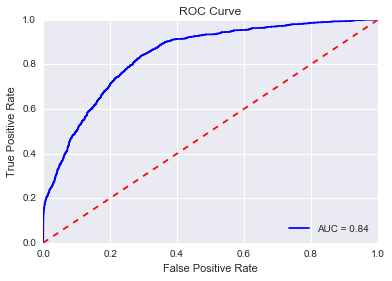

In [85]:
# calculate the fpr and tpr for all thresholds of the classification
probas = svm_clf.predict_proba(X_test)
svm_preds = probas[:,1]
svm_fpr, svm_tpr, svc_threshold = metrics.roc_curve(y_test, svm_preds)
svm_roc_auc = metrics.auc(svm_fpr, svm_tpr)

print "The Area Under the ROC Curve: %f" % svm_roc_auc + \
      "\nGini: " + str(format(2*svm_roc_auc-1, '.3f'))
    
# plot ROC curve
plt.title('ROC Curve')
plt.plot(svm_fpr, svm_tpr, 'b', label = 'AUC = %0.2f' % svm_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a name="evaluation"></a>
# IV. Evaluation

<a name="performance_compare"></a>
### Model Performance Comparision

Logisitic Regression: 
   Accuracy Score:  0.813
   RMSE:            0.432

Decision Tree: 
   Accuracy Score:  0.830
   RMSE:            0.413

Naive Bayes: 
   Accuracy Score:  0.801
   RMSE:            0.446

Linear SVC: 
   Accuracy Score:  0.801
   RMSE:            0.446


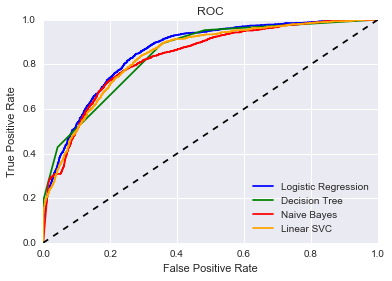

In [86]:
print "Logisitic Regression: \n   Accuracy Score:  " + \
      str(format(metrics.accuracy_score(y_test, lr_predicted), '.3f')) + \
      "\n   RMSE:            " + \
      str(format(sqrt(metrics.mean_squared_error(y_test, lr_predicted)), '.3f')) +\
      "\n\nDecision Tree: \n   Accuracy Score:  " + \
      str(format(metrics.accuracy_score(y_test, dt_predicted), '.3f')) + \
      "\n   RMSE:            " + \
      str(format(sqrt(metrics.mean_squared_error(y_test, dt_predicted)), '.3f')) +\
      "\n\nNaive Bayes: \n   Accuracy Score:  " + \
      str(format(metrics.accuracy_score(y_test, gnb_predicted), '.3f')) + \
      "\n   RMSE:            " + \
      str(format(sqrt(metrics.mean_squared_error(y_test, gnb_predicted)), '.3f')) +\
      "\n\nLinear SVC: \n   Accuracy Score:  " + \
      str(format(metrics.accuracy_score(y_test, svm_predicted), '.3f')) + \
      "\n   RMSE:            " + \
      str(format(sqrt(metrics.mean_squared_error(y_test, svm_predicted)), '.3f'))
    
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression', color='blue')
plt.plot(dt_fpr, dt_tpr, label='Decision Tree', color='green')
plt.plot(gnb_fpr, gnb_tpr, label='Naive Bayes', color='red')
plt.plot(svm_fpr, svm_tpr, label='Linear SVC', color='orange')
plt.plot([0, 1], [0, 1],'r--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

<a name="conclusion"></a>
## Conclusion

This tutorial is intended only to give you a basic introduction to using Python and Scikit-learn for data analysis and modeling. Scikit-learn offers a wide array of machine learning models and data transformation techniques, check out their website for more information and tutorials [Scikit-learn](http://scikit-learn.org/stable/index.html).

If you find any mistakes or a better/more efficient way to code something in this tutorial please send me your code. This notebook will be a working progress.